# Summary of Data #2

The aim of this notebook is to plot visualizations for each of the different environments separately.
Things we need to visualize/quantify:
1. Impulse Response ($H(F)$)
2. Impulse Response given RIS's phase ($\Phi$)
3. Impulse Response given perturber's orientation ($\theta$)


In [ ]:
import os
os.chdir(os.getcwd()+'/../')
print(os.getcwd())

/home/kyriakos/workspace/reasearch/RIS/deep_RIS_scattering



The dataset includes data for three different reverberation times (in other words, how lossy is the environment, how often does the wave bounce around before being absorbed) and three different scattering strengths of the dynamic perturber. Each time, the transmission between a pair of antennas (fixed position) is measured at 30 frequency points for 500 random RIS configurations, and 100 random perturber realizations. We can adjust the simulation setup and/or produce more data if needed but hopefully the attached dataset is a good starting point. We haven't taken a closer look at the dataset so far.

The variables in the filenames, $qq$ and $ll$, identify reverberation time ($qq=1$ largest, $qq=3$ lowest) and perturber size ($ll=1$ smallest, $ll=3$ largest). Within each file are the following variables:

- $L pert$       is the perturber size (length).
- $PertOrient$   is the angular orientation of the perturber for each transmission measurement.
- $RIS configs$  contains the binary configuration of the 21 element RIS for each transmission measurement.
- $freq$         is the 30-element frequency vector (in arbitrary units, the central frequency is 1).
- $Transmission$ are the S12 measurements between TX and RX for the 30 frequencies for 100 random perturber realizations and 500 random RIS configurations.

----------------

# Section 0: Importing data

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import scipy.io
import matplotlib.colors

In [4]:
DATA_DIR        = './data/summary/'
FILENAME_FORMAT = DATA_DIR + 'SUMMARY qq={:d} ll={:d}.mat'
QQ_VALUES       = [1,2,3]
LL_VALUES       = [1,2,3]

LL = 1
QQ = 3

In [5]:
setups = np.empty(shape=(len(QQ_VALUES), len(LL_VALUES)), dtype=object)

For each setup we will create a `dict` with the following fields:

1. `L_pert` : `int`
2. `PertOrient` : (100,500) `float`
3. `RIS_config` : (100,500, 21) `int` (binary)
4. `Transmission`: (100,500, 30) `complex float`
5. `Frequency` : (30) `int`

In [6]:
def mat2dict(mat):
    L_pert       = mat['L_pert'][0,0]
    PertOrient   = mat['PertOrient']
    RIS_configs  = mat['RIS_configs']
    Transmission = mat['Transmission']
    freq         = mat['freq'].flatten()
    
    data = dict()
    data['L_pert']       = L_pert
    data['PertOrient']   = PertOrient
    data['RIS_config']   = RIS_configs
    data['Transmission'] = Transmission
    data['Frequency']    = freq
    
    return data



for i, qq in enumerate(QQ_VALUES):
    for j, ll in enumerate(LL_VALUES):        
        filename       = FILENAME_FORMAT.format(qq, ll)
        mat            = scipy.io.loadmat(filename)
        data           = mat2dict(mat)
        setups[i,j]    = data

# Section 1: Plot density plots of impulse responses for each plot

In [7]:
from itertools import product


def get_setup_names():
    assert len(QQ_VALUES) == len(LL_VALUES)
    return [f"QQ: {qq}, LL: {ll}" for qq,ll in product(QQ_VALUES, repeat=2)]

get_setup_names()

['QQ: 1, LL: 1',
 'QQ: 1, LL: 2',
 'QQ: 1, LL: 3',
 'QQ: 2, LL: 1',
 'QQ: 2, LL: 2',
 'QQ: 2, LL: 3',
 'QQ: 3, LL: 1',
 'QQ: 3, LL: 2',
 'QQ: 3, LL: 3']

In [ ]:
def density_plot_of_impulse_responses(setups):
    
    fig, axes = plt.subplots(2,9, figsize=(35,6))
    fig.suptitle('Distribution of S12 measurements ($H(f)$) for all setups. (All frequencies merged together)',
                 fontsize=24)

    pal = sns.cubehelix_palette(9, rot=-.25, light=.7)
    names = get_setup_names()
    
    with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        col = 0
        axes[0,0].set_ylabel(r'$Re(H(f))$')
        axes[1,0].set_ylabel(r'$Im(H(f))$')
        
        for i, qq in enumerate(QQ_VALUES):
            for j, ll in enumerate(LL_VALUES):
                data = setups[i,j]
                x = data['Transmission'].flatten()
                sns.distplot(x.real, ax=axes[0, col], color=pal[col])
                sns.distplot(x.imag, ax=axes[1, col], color=pal[col])
                
                axes[1,col].set_xlabel(names[col])
                axes[0,col].set_xticks([])
                axes[1,col].set_xticks([])
                axes[0,col].set_yticks([])
                axes[1,col].set_yticks([])
                col += 1
                
                
                
                
    
    plt.xlim([-1,1])
    #plt.subplots_adjust(top=-.05)
    plt.show()
    

density_plot_of_impulse_responses(setups)

In [ ]:
def density_plot_of_impulse_responses_per_frequency_point(setups):
    
    
    frequency_points = setups[0,0]['Frequency']
    
    
    for f, frequency in enumerate(frequency_points):
    
        fig, axes = plt.subplots(2,9, figsize=(35,6))
        fig.suptitle(f'Distribution of $H(f)$ for all setups. (Frequency: {frequency})',
                     fontsize=24)


        pal = sns.cubehelix_palette(9, rot=-.25, light=.7)
        names = get_setup_names()

        with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
            col = 0
            axes[0,0].set_ylabel(r'$Re(H(f))$')
            axes[1,0].set_ylabel(r'$Im(H(f))$')

            for i, qq in enumerate(QQ_VALUES):
                for j, ll in enumerate(LL_VALUES):
                    data = setups[i,j]
                    x = data['Transmission'].reshape(-1, len(frequency_points))[:,f]
                    sns.distplot(x.real, ax=axes[0, col], color=pal[col])
                    sns.distplot(x.imag, ax=axes[1, col], color=pal[col])

                    axes[1,col].set_xlabel(names[col])
                    axes[0,col].set_xticks([])
                    axes[1,col].set_xticks([])
                    axes[0,col].set_yticks([])
                    axes[1,col].set_yticks([])
                    col += 1

        plt.xlim([-1,1])
        #plt.subplots_adjust(top=-.05)
        plt.show()


density_plot_of_impulse_responses_per_frequency_point(setups)

In [12]:
x = setups[0,0]['Transmission'].flatten()
g = np.tile(np.arange(1,31), (100*500))

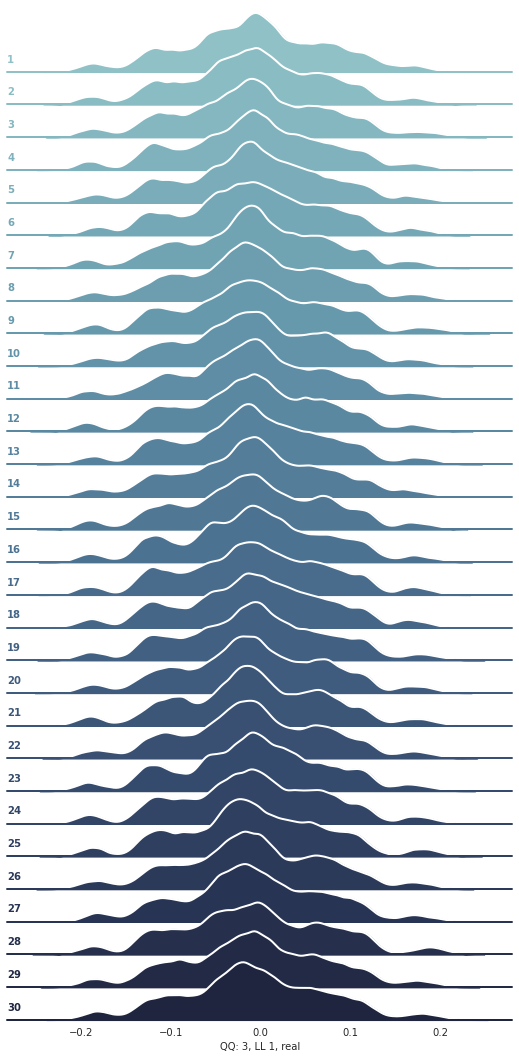

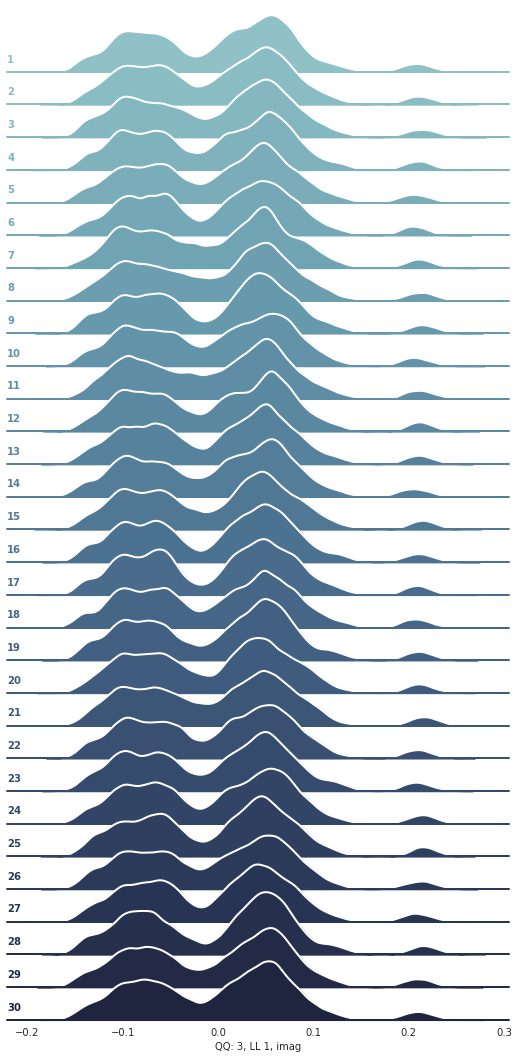

In [20]:
def ridge_plot_responses_per_frquency(setups, qq, ll, real_or_imag):
    assert real_or_imag in ['real', 'imag']
    
    n_frequencies = setups[qq-1,ll-1]['Transmission'].shape[-1]
    n_datapoints  = np.prod(setups[qq-1,ll-1]['Transmission'].shape[:-1])

    x_name        = f'QQ: {qq}, LL {ll}, {real_or_imag}'
    
    x  = setups[qq-1,ll-1]['Transmission'].flatten()
    x  = x.real if real_or_imag == 'real' else x.imag
    g  = np.repeat(np.arange(1,n_frequencies+1), n_datapoints)
    df = pd.DataFrame({x_name : x,
                       'g'    : g})


    filename = f'./plots/data2/rigdeplot_frequencies_{qq}_{ll}_{real_or_imag}.png'

    with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        # Initialize the FacetGrid object
        pal = sns.cubehelix_palette(30, rot=-.25, light=.7)
        g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal,)
                         #xlim=[-1,1]

        # Draw the densities in a few steps
        g.map(sns.kdeplot, x_name,
              bw_adjust=.5, clip_on=False,
              fill=True, alpha=1, linewidth=1.5)
        g.map(sns.kdeplot, x_name, clip_on=False, color="w", lw=2, bw_adjust=.5)
        g.map(plt.axhline, y=0, lw=2, clip_on=False)


        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                    ha="left", va="center", transform=ax.transAxes)


        g.map(label, x_name)

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.5)

        # Remove axes details that don't play well with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)
        
        plt.savefig(filename)
        plt.show()
        

        
for qq in [3]:#QQ_VALUES:
    for ll in [1]:#LL_VALUES:
        ridge_plot_responses_per_frquency(setups, qq, ll, 'real')
        ridge_plot_responses_per_frquency(setups, qq, ll, 'imag')
        

-------------------

# Section 2: Responses per Phase Configuration
-----------

In [22]:
def multi_ridge_plot(x, labels, x_name, filename=None):
    
    
    assert x.ndim == 2
    g = np.repeat(labels, x.shape[0])
    x = x.flatten()
    df = pd.DataFrame({x_name : x,
                       'g'    : g})
    
    with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        # Initialize the FacetGrid object
        pal = sns.cubehelix_palette(30, rot=-.25, light=.7)
        g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal,)
                         #xlim=[-1,1]

        # Draw the densities in a few steps
        g.map(sns.kdeplot, x_name,
              bw_adjust=.5, clip_on=False,
              fill=True, alpha=1, linewidth=1.5)
        g.map(sns.kdeplot, x_name, clip_on=False, color="w", lw=2, bw_adjust=.5)
        g.map(plt.axhline, y=0, lw=2, clip_on=False)


        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                    ha="left", va="center", transform=ax.transAxes)


        g.map(label, x_name)

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.5)

        # Remove axes details that don't play well with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)
        
        if filename: plt.savefig(filename)
        plt.show()

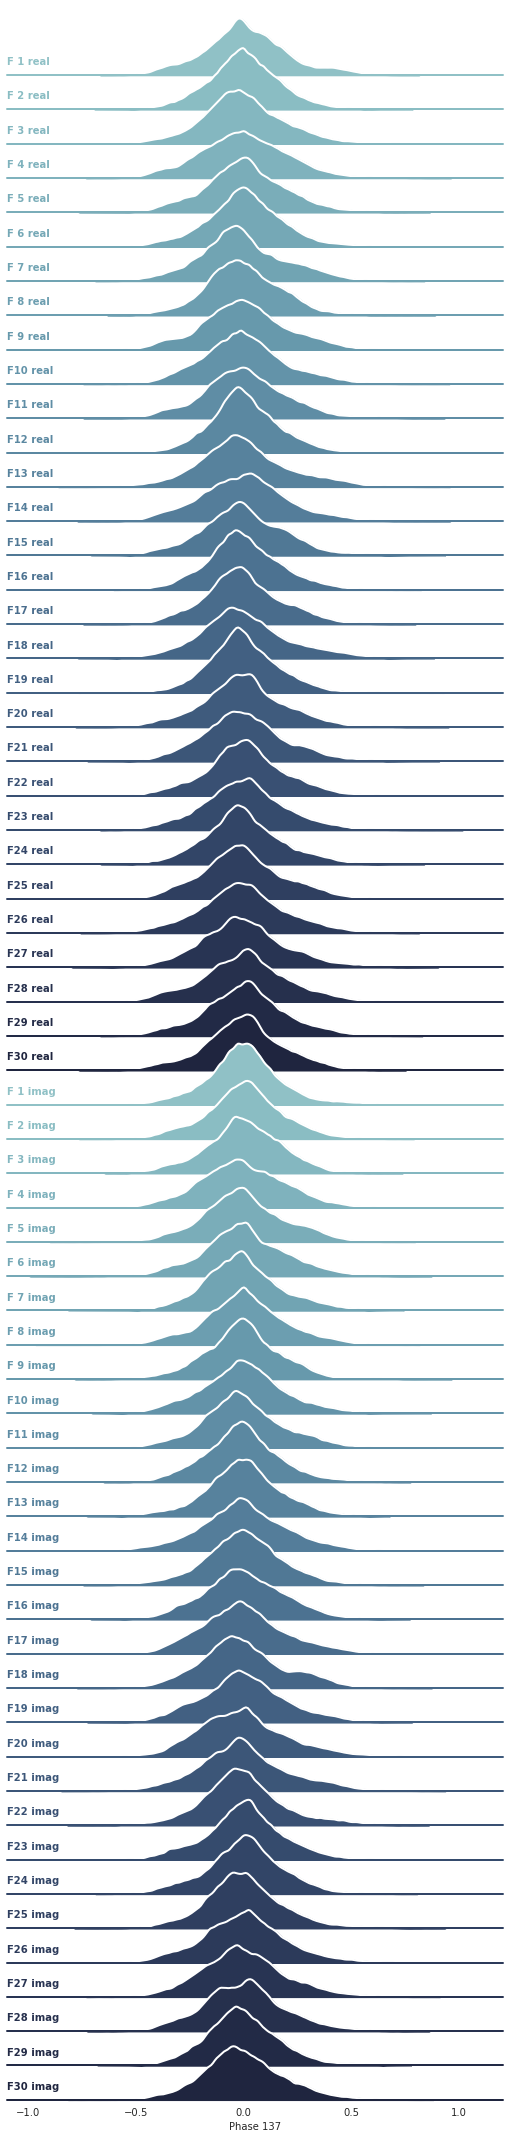

In [28]:
qq = 2
ll = 2
X = setups[qq-1,ll-1]['Transmission']
X = np.concatenate([X.real, X.imag], axis=2)

phase_indices = [137]#np.random.randint(0, X.shape[1], 5)


for phase in phase_indices:
    X_phase    = X.reshape((-1, X.shape[2]))
    labels     = ["F{:2d} real".format(i+1) for i in range(X_phase.shape[1]//2)] + ["F{:2d} imag".format(i+1) for i in range(X_phase.shape[1]//2)]
    filename   = f'./plots/data/ridgeplot_{qq}_{ll}_responses_for_phase_{phase}.pdf'
    
    multi_ridge_plot(X_phase, labels, f'Phase {phase}', filename)



-------
# Section 3: Impulse responses per perturber orientation
----